In [1]:
%load_ext autoreload
%autoreload

import pandas as pd; pd.set_option('display.max_columns', 30)
import numpy as np
from cmlreaders import CMLReader, get_data_index
import ptsa
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sb
from pylab import *
from copy import copy
from scipy import stats
plt.rcParams['pdf.fonttype'] = 42; plt.rcParams['ps.fonttype'] = 42 # fix fonts for Illustrator
sys.path.append('/home1/john/SWRrefactored/code/SWR_modules/')
from SWRmodule import *
from general import * #superVstack,findInd,findAinB
from power_functions import z_score, process_power, load_z_scored_power

base = '/home1/john/SWRrefactored'
sys.path.append(f'{base}/code/')

from load_data_numpy import load_data_np
from SWRmodule import triangleSmooth
# from comodulogram import remove_session_string, get_filtered_signal
# from fooof import FOOOF

import statsmodels.formula.api as smf
from scipy.signal import decimate, resample, hilbert, welch, spectrogram
from mne.time_frequency import tfr_array_morlet

# # Import the time & event model objects and Bands object to manage oscillation band definitions
# from specparam import SpectralTimeModel, SpectralTimeEventModel, Bands
# # Import helper utilities for simulating and plotting spectrograms
# from specparam.sim import sim_spectrogram
# from specparam.plts.spectra import plot_spectrogram

In /home1/john/anaconda3/envs/workshopJ/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home1/john/anaconda3/envs/workshopJ/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home1/john/anaconda3/envs/workshopJ/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home1/john/anaconda3/envs/workshopJ/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /

In [180]:
np.logspace(np.log10(80),np.log10(178),10)

array([ 80.        ,  87.43437519,  95.55962457, 104.43995085,
       114.1455231 , 124.75303116, 136.34629167, 149.01691027,
       162.86500554, 178.        ])

In [3]:
# for now the plotting code only works with one region at a time
region_name = ['HPC'] # ['ENT'] # ['AMY']
subregion = ['ca1'] #['ca1'] # can use [''] to select ALL subregions
task = 'catFR1' # 'catFR1'
savePath = f'{base}/figures/'

# 1 for encoding, 0 for recall
encoding_mode_arr = [1] #[0,1] 
freq_range_str_arr = [[33.5,75],[80,178],[2,4],[7,9]] # [80,178]
# these were selecetd to avoid 60 and 120 Hz using np.logspace(np.log10(30),np.log10(75),10)

# define frequency ranges
buffer = 2000 # time in ms to buffer trials (for Morlet)

plot_error_bars = True

fs = 500 # sampling rate for raw data and ripples from createEventsForDF.py

In [4]:
# np.shape(dd_trials['ripple'])
# np.shape(dd_trials['raw'])
# dd_trials.keys()
# np.unique(dd_trials['elec_labels'])

In [5]:
for encoding_mode in encoding_mode_arr:

    dd_trials = load_data_np(encoding_mode,task,
        region_name=region_name, train_only=False, subregion=subregion)
    
    region_str = region_name[0]
    subregion_str = subregion[0]
    
    clust = dd_trials['clust_int']
    notclust_idxs = np.argwhere(clust<0).squeeze()
    clust_idxs = np.argwhere(clust>0).squeeze()
    
    if encoding_mode:
        saveName = 'encoding_'
        recall_str = ''
        time = np.linspace(-0.7, 2.3, 150)
        correct = dd_trials['correct']
        incorrect_idxs = np.argwhere(correct==0).squeeze()
        start_cutoff = 300 # times (in s) relative to word_on 
        end_cutoff = 1300 
        
    else:
        saveName = 'recall_'
        recall_str = '_recall'
        time = np.linspace(-2, 2, 200)
        start_cutoff = -1000
        end_cutoff = 0      
        
    # convert time ranges to samples
    sr_factor = 1000/fs
    # data taken is from -1.7 to 3.3 s from word_on so account for that by adding 1700 ms
    start_cutoff = 0
    end_cutoff = 2500 # just take the whole range of data to better estimate Morlet
#     start_cutoff = int((1700+start_cutoff-buffer)/sr_factor) # this comes to 0:2500 anyway
#     end_cutoff = int((1700+end_cutoff+buffer)/sr_factor)     # ...so just index in time from here
    
    
    print("Generating figures for run_mode: ", encoding_mode)
    # starts with high and moves to low
    power_z = load_z_scored_power(dd_trials, freq_range_str_arr, encoding_mode,fs,start_cutoff, end_cutoff)
        
    # note that output is 50 Hz (20 ms bins) since started 500 hz and decimated 10x
    if len(subregion[0]) > 0:
        subregion_str = f'_{subregion[0]}'
    else:
        subregion_str = ''           

a=1;            

Loading data
LOADING DATA FROM: HPC FOR EXPERIMENT catFR1


/home1/john/anaconda3/envs/workshopJ/lib/python3.7/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


elec_by_elec_correlation
elec_by_elec_correlation
elec_by_elec_correlation
elec_by_elec_correlation
elec_by_elec_correlation
elec_by_elec_correlation
elec_by_elec_correlation
elec_by_elec_correlation
elec_by_elec_correlation
elec_by_elec_correlation
elec_by_elec_correlation
elec_by_elec_correlation
elec_by_elec_correlation
elec_by_elec_correlation
elec_by_elec_correlation
elec_by_elec_correlation
order: C


/home1/john/SWRrefactored/code/SWR_modules/load_data.py:433: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  dd_trials[key] = np.asarray(val)


Generating figures for run_mode:  1


In [15]:
dd_trials.keys()
np.shape(dd_trials['ripple'])
np.shape(dd_trials['raw'])

np.shape(power_z)
freq_range_str_arr

unique_subs = np.unique(dd_trials['subj'])
unique_subs

dict_keys(['ripple', 'clust', 'correct', 'position', 'list_num', 'subj', 'sess', 'elec_names', 'elec_labels', 'serial_pos', 'raw', 'elec_by_elec_correlation', 'trial_by_trial_correlation', 'elec_ripple_rate_array', 'category_array', 'clust_int'])

(18408, 1500)

(18408, 2500)

(4, 18408, 250)

[[33.5, 75], [80, 178], [2, 4], [7, 9]]

array(['R1108J', 'R1112M', 'R1486J', 'R1501J', 'R1525J'], dtype='<U6')

In [183]:
gamma_sd_thresh = 1.0

# select a patient
patient_idx = -1
if patient_idx >-1: 
    sub_idxs = dd_trials['subj']==unique_subs[patient_idx]
else:
    sub_idxs = np.ones(len(dd_trials['subj']),dtype=bool)
print(f'Number of trials: {sum(sub_idxs)} from the following subs:')
np.unique(dd_trials['subj'][sub_idxs])
      
sub_ripples = dd_trials['ripple'][sub_idxs] # ripples are detected from -0.7 to 2.3 s @ 500 Hz
sub_Zs = power_z[:,sub_idxs,:]
np.shape(sub_Zs)
ripple_start_offset = -700 # ripple matrix starts 700 ms before word_on
ripple_start = 300 # time in ms
ripple_end = 1300 # time in ms

# note only +700 since ripple_trials go from -0.7 to 2.3 s (no buffers)
ripple_trials = np.sum(sub_ripples[:,int((-ripple_start_offset+ripple_start)/sr_factor):
                                   int((-ripple_start_offset+ripple_end)/sr_factor)],1)>0
print(f'{sum(ripple_trials)} trials have ripples which is {np.round(100*sum(ripple_trials)/sum(sub_idxs),2)}% of total')

z_factor = sr_factor*10 # z_score was decimated 10x
# average z-score over time for same range as ripples
ripple_time_range = slice(int((1700+ripple_start)/z_factor),int((1700+ripple_end)/z_factor)) # +1700 since goes from -1.7 to 3.3 s
z_low_gamma_trials = np.mean(sub_Zs[0,:,ripple_time_range],1)>gamma_sd_thresh
z_high_gamma_trials = np.mean(sub_Zs[1,:,ripple_time_range],1)>gamma_sd_thresh

Number of trials: 18408 from the following subs:


array(['R1108J', 'R1112M', 'R1486J', 'R1501J', 'R1525J'], dtype='<U6')

(4, 18408, 250)

5473 trials have ripples which is 29.73% of total


12

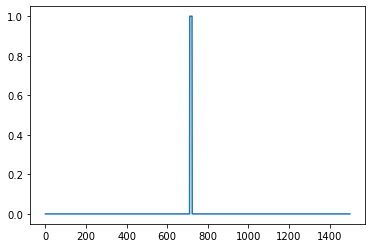

In [176]:
plt.plot(sub_ripples[1])
sum(sub_ripples[1])

start_array,_ = getStartEndArrays(sub_ripples)
# first bin has artificially high number due to how start_srray workxs
start_array = start_array[:,1:] 
print(f'start array shape: {np.shape(start_array)}')

In [249]:
np.shape(start_array[clust_clustered,ripple_swarm_start:ripple_swarm_end])
np.sum(start_array[clust_clustered,ripple_swarm_start:ripple_swarm_end],1)


(3536, 500)

array([0, 1, 1, ..., 0, 0, 0], dtype=uint64)

1484

In [252]:
sum(clust_clustered)
np.shape(np.sum(start_array[clust_clustered,ripple_swarm_start:ripple_swarm_end],1))
np.unique(np.sum(start_array[clust_clustered,ripple_swarm_start:ripple_swarm_end],1))

3536

(3536,)

array([0, 1, 2, 3, 4, 5, 6], dtype=uint64)

/home1/john/SWRrefactored/code/SWR_modules/SWRmodule.py:1389: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  norm_count = count/np.array((num_trials*binsize/1000))


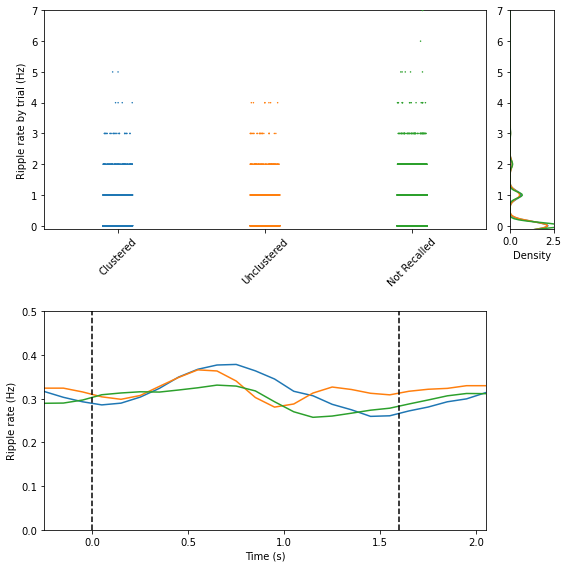

In [270]:
import seaborn as sb
from scipy.signal import decimate
import matplotlib.gridspec as gridspec

# Function parameters
bin_size = 100  # in ms
smoothing_triangle = 5  # triangular smoothing window width
swarm_ylimits = (-0.1,7)

trial_select = ~z_low_gamma_trials

ripple_swarm_start = int((-ripple_start_offset+ripple_start)/sr_factor)
ripple_swarm_end = int((-ripple_start_offset+ripple_end)/sr_factor)
ripple_swarm_duration = (ripple_end-ripple_start)/1000 # convert to seconds

# Apply the clust variable to split data into clustered, unclustered, and not recalled
clust_clustered = clust > 1
clust_unclustered = clust < 0
clust_not_recalled = clust == 0

# calculate ripple means for each
mean_ripple_clustered = np.sum(start_array[trial_select&clust_clustered,ripple_swarm_start:ripple_swarm_end],1)/ripple_swarm_duration
mean_ripple_unclustered = np.sum(start_array[trial_select&clust_unclustered,ripple_swarm_start:ripple_swarm_end],1)/ripple_swarm_duration
mean_ripple_not_recalled = np.sum(start_array[trial_select&clust_not_recalled,ripple_swarm_start:ripple_swarm_end],1)/ripple_swarm_duration
               
# Set up the figure with GridSpec
fig = plt.figure(figsize=(8, 8))
gs = gridspec.GridSpec(2, 4, height_ratios=[2, 2], width_ratios=[3,3,3,1])

# Bin and combine data for swarm plot
data_combined = np.concatenate([mean_ripple_clustered, mean_ripple_unclustered, mean_ripple_not_recalled])
labels = (['Clustered'] * len(mean_ripple_clustered) +
          ['Unclustered'] * len(mean_ripple_unclustered) +
          ['Not Recalled'] * len(mean_ripple_not_recalled))

# Create the swarmplot (span all columns)
ax_swarm = fig.add_subplot(gs[0, :3])
sb.stripplot(x=labels, y=data_combined, palette=[palette['Clustered'], palette['Unclustered'], palette['Not Recalled']], size=1.5,jitter=True)
# sb.swarmplot(x=labels, y=data_combined, palette=[palette['Clustered'], palette['Unclustered'], palette['Not Recalled']], size=1.5,jitter=True)
ax_swarm.set_ylabel('Ripple rate by trial (Hz)')
ax_swarm.set_xlabel('')
ax_swarm.set_ylim(swarm_ylimits)
ax_swarm.set_xticklabels(ax_swarm.get_xticklabels(), rotation=45, ha="center")

# Add the KDE plot to the right of the swarm plot
ax_kde = fig.add_subplot(gs[0, 3])
sb.kdeplot(y=mean_ripple_clustered, ax=ax_kde, color=palette['Clustered'], fill=False, label='Clustered',common_norm=False)
sb.kdeplot(y=mean_ripple_unclustered, ax=ax_kde, color=palette['Unclustered'], fill=False, label='Unclustered',common_norm=False)
sb.kdeplot(y=mean_ripple_not_recalled, ax=ax_kde, color=palette['Not Recalled'], fill=False, label='Not Recalled',common_norm=False)
ax_kde.set_ylim(swarm_ylimits)
ax_kde.set_xlabel('Density')
ax_kde.set_xlim(0,2.5)

# Calculate PSTH for each group
ripple_PSTH_clustered, bin_centers = fullPSTH(start_array[trial_select&
clust_clustered], bin_size, smoothing_triangle, fs, ripple_start_offset)
ripple_PSTH_unclustered, _ = fullPSTH(start_array[trial_select&
clust_unclustered], bin_size, smoothing_triangle, fs, ripple_start_offset)
ripple_PSTH_not_recalled, _ = fullPSTH(start_array[trial_select&
clust_not_recalled], bin_size, smoothing_triangle, fs, ripple_start_offset)

ax_psth = fig.add_subplot(gs[1, :3])
ax_psth.plot(bin_centers/1000, ripple_PSTH_clustered, label='Clustered', color=palette['Clustered'])
ax_psth.plot(bin_centers/1000, ripple_PSTH_unclustered, label='Unclustered', color=palette['Unclustered'])
ax_psth.plot(bin_centers/1000, ripple_PSTH_not_recalled, label='Not Recalled', color=palette['Not Recalled'])
ax_psth.axvline(x=0.0, color='black', linestyle='--')
ax_psth.axvline(x=1.6, color='black', linestyle='--')
ax_psth.set_xlabel('Time (s)')
ax_psth.set_xlim(-0.25, 2.05)
ax_psth.set_ylim(0,0.5)
ax_psth.set_ylabel('Ripple rate (Hz)')

# Adjust layout
plt.tight_layout(h_pad=2)
plt.show();


In [265]:
mean_ripple_clustered
np.unique(mean_ripple_clustered)
len(mean_ripple_clustered)

array([1., 0., 0., ..., 0., 0., 0.])

array([0., 1., 2., 3., 4., 6.])

1041

In [ ]:
to get error bars:
    

In [ ]:
# get binned start array (trials X bins)
    binned_start_array = binBinaryArray(temp_start_array,bin_size,sr_factor)
    print('done making binned start_array with shape:')
    print(binned_start_array.shape)

    # note that output is the net ± distance from mean
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")    
        mean_plot,SE_plot = getMixedEffectMeanSEs(binned_start_array,sub_name_array,sess_name_array)
    print('SEs created!')
    
    if plot_ME_mean == 1:
        PSTH = triangleSmooth(mean_plot,smoothing_triangle) # replace PSTH with means from ME model (after smoothing as usual)  
    elif plot_ME_mean == 2:
        temp_means = []
        for sub in np.unique(sub_name_array):
            temp_means = superVstack(temp_means,np.mean(binned_start_array[np.array(sub_name_array)==sub],0))
        PSTH = triangleSmooth(np.mean(temp_means,0),smoothing_triangle)
        SE_sub_level = np.std(temp_means,0)/np.sqrt(len(temp_means)) 

In [11]:
sum(~ripple_trials & z_high_gamma_trials)
sum(~ripple_trials & z_low_gamma_trials)
sum(~ripple_trials & z_low_gamma_trials & z_high_gamma_trials)
sum(ripple_trials & z_low_gamma_trials)
sum(ripple_trials & z_low_gamma_trials & z_high_gamma_trials)

1047

1004

317

985

541

In [12]:
sum(ripple_trials & z_high_gamma_trials)
sum(z_low_gamma_trials & ripple_trials)
sum(z_low_gamma_trials & z_high_gamma_trials)
sum(~ripple_trials & z_high_gamma_trials)
sum(z_low_gamma_trials & ~ripple_trials)
sum(z_low_gamma_trials & ~z_high_gamma_trials)

1518

985

858

1047

1004

1131

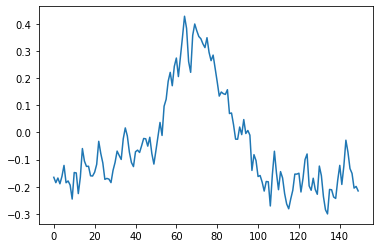

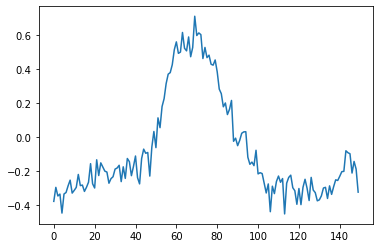

In [13]:
for pp in range(2):
    plt.plot(np.mean(power_z[pp,:,50:200],0))
    plt.show() 
    

# Ebrahim's combo of HFA/theta figures

In [14]:
for encoding_mode in encoding_mode_arr:

    dd_trials = load_data_np(encoding_mode,task,
        region_name=region_name, train_only=False, subregion=subregion)
    
    region_str = region_name[0]
    subregion_str = subregion[0]
    
    ### clust key ###
    # -2: dead end, -1 remote unclustered, 0 not recalled, 
    # +1 temporal adjacent, +2 remote semantic, +3 adjacent semantic    
    #################
    clust = dd_trials['clust_int']
    notclust_idxs = np.argwhere(clust<0).squeeze()
    clust_idxs = np.argwhere(clust>0).squeeze()
    
    if encoding_mode:
        saveName = 'encoding_'
        recall_str = ''
        time = np.linspace(-0.7, 2.3, 150)
        correct = dd_trials['correct']
        incorrect_idxs = np.argwhere(correct==0).squeeze()
        
    else:
        saveName = 'recall_'
        recall_str = '_recall'
        time = np.linspace(-2, 2, 200)
    
    # times relative to -1.7 to 3.3 s from word_on
#     start_time = 
    for power_z, ylabel in load_z_scored_power(dd_trials, freq_range_str_arr, encoding_mode,
                                              high_fq_range, low_fq_range):

        if len(subregion[0]) > 0:
            subregion_str = f'_{subregion[0]}'
        else:
            subregion_str = ''
            
        if 'Gamma' in ylabel:
            fq_range = high_fq_range
        elif 'Theta' in ylabel:
            fq_range = low_fq_range
    
        # loop through sub-bands of gamma or theta
        for power_z_i, f in zip(power_z, fq_range): 

            plt.figure(figsize=(10,6))

            # Calculate mean and SEM
            mean_clust = np.mean(power_z_i[clust_idxs].squeeze(), axis=0)
            mean_not_clust = np.mean(power_z_i[notclust_idxs].squeeze(), axis=0)
            sem_clust = np.std(power_z_i[clust_idxs].squeeze(), axis=0) / np.sqrt(len(clust_idxs))
            sem_not_clust = np.std(power_z_i[notclust_idxs].squeeze(), axis=0) / np.sqrt(len(notclust_idxs))
            
            # Apply smoothing
            mean_clust_smooth = triangleSmooth(mean_clust, smoothing_triangle=5)
            mean_not_clust_smooth = triangleSmooth(mean_not_clust, smoothing_triangle=5)
            sem_clust_smooth = triangleSmooth(sem_clust, smoothing_triangle=5)
            sem_not_clust_smooth = triangleSmooth(sem_not_clust, smoothing_triangle=5)

            # Plotting
            plt.plot(time, mean_clust_smooth, color='tab:blue', alpha=0.8, label="Clust")
            plt.plot(time, mean_not_clust_smooth, color='tab:orange', alpha=0.8, label="Not Clust")
            
            if plot_error_bars:
                plt.fill_between(time, mean_clust_smooth - sem_clust_smooth, mean_clust_smooth + sem_clust_smooth, 
                                 color='tab:blue', alpha=0.3)
                plt.fill_between(time, mean_not_clust_smooth - sem_not_clust_smooth, mean_not_clust_smooth + sem_not_clust_smooth,
                                 color='tab:orange', alpha=0.3)
                
            # plot not recalled data for encoding 
            if encoding_mode:
                mean_not_recalled = np.mean(power_z_i[incorrect_idxs].squeeze(), axis=0)
                mean_not_recalled_smooth = triangleSmooth(mean_not_recalled, smoothing_triangle=5)
                
                sem_not_recalled = np.std(power_z_i[incorrect_idxs].squeeze(), axis=0) / np.sqrt(len(incorrect_idxs))
                sem_not_recalled_smooth = triangleSmooth(sem_not_recalled, smoothing_triangle=5)
                                                    
                plt.plot(time, mean_not_recalled_smooth, color='tab:pink', alpha=0.8, label="Not Recalled")
                
                if plot_error_bars:
                    plt.fill_between(time, mean_not_recalled - sem_not_recalled_smooth, 
                                     mean_not_recalled + sem_not_recalled_smooth, color='tab:pink', alpha=0.3)
                

            plt.axvline(0, color='black')
            plt.ylabel(f"{ylabel} ({f[0]}-{f[1]} Hz)", fontsize=18)
            plt.xlabel("Time", fontsize=18)
            sb.despine()
            plt.legend(fontsize=16)
            plt.savefig(f"{savePath}/{ylabel}_{f[0]}-{f[1]}_zscore_elec_{region_str}{subregion_str}{recall_str}", dpi=300, 
                        bbox_inches='tight')
            plt.savefig(f"{savePath}/{ylabel}_{f[0]}-{f[1]}_zscore_elec_{region_str}{subregion_str}{recall_str}.pdf",
                        bbox_inches='tight')
            plt.show()
a=1;            

Loading data
LOADING DATA FROM: HPC FOR EXPERIMENT catFR1


/home1/john/anaconda3/envs/workshopJ/lib/python3.7/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


elec_by_elec_correlation
elec_by_elec_correlation
elec_by_elec_correlation
elec_by_elec_correlation
elec_by_elec_correlation
elec_by_elec_correlation
elec_by_elec_correlation
elec_by_elec_correlation
elec_by_elec_correlation
elec_by_elec_correlation
elec_by_elec_correlation
elec_by_elec_correlation
elec_by_elec_correlation
elec_by_elec_correlation
elec_by_elec_correlation
elec_by_elec_correlation
order: C


/home1/john/SWRrefactored/code/SWR_modules/load_data.py:433: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  dd_trials[key] = np.asarray(val)


NameError: name 'high_fq_range' is not defined

In [ ]:
plt.plot(np.mean(filtered_sig_power[2, selected_elec_idxs].squeeze(),axis=0))
plt.show()
plt.plot(np.mean(filtered_sig_power[1, selected_elec_idxs].squeeze(),axis=0))
plt.show()
plt.plot(np.mean(filtered_sig_power[0, selected_elec_idxs].squeeze(),axis=0))
plt.show()


In [ ]:
from neurodsp.timefrequency.wavelets import compute_wavelet_transform
from mne.time_frequency import tfr_array_morlet
from neurodsp.plts import plot_time_series, plot_timefrequency

In [ ]:
frequencies_low = [1,2,3,4,5,6,7,8,9,10]
frequencies_high = np.arange(10,156,5)
frequencies = np.hstack((frequencies_low, frequencies_high))
n_freqs = frequencies.shape[0]
n_cycles = np.floor(np.linspace(2,15,n_freqs))

In [ ]:
# Define general settings for across the example
for selected_elec in np.unique(subj_elec_sess_labels):
    print(selected_elec)
    #selected_elec = best_power_elec
    selected_elec_idxs = np.argwhere(subj_elec_sess_labels==selected_elec)
    raw_data_elec = raw_data[selected_elec_idxs].squeeze()
    fs = 500

    buffer = 500

    power_elec = tfr_array_morlet(np.expand_dims(raw_data_elec, axis=1), sfreq=500, 
                                  freqs=frequencies, output='power', n_cycles=n_cycles)
    mwt = np.mean(power_elec.squeeze()[:, :, buffer:-buffer],axis=0) 

    # Define the baseline period as -500 ms to -100 ms 
    baseline_pow = np.mean(mwt[:, 100:300],axis=1)

    mwt = mwt/np.expand_dims(baseline_pow,axis=1)

    mwt_decibal = 10 * np.log10(mwt[:, 350:1100])

    # plot data from 0 - 1500 ms 
    times = np.linspace(0,1.5,750)
    plt.pcolormesh(times, frequencies, mwt_decibal, shading='gouraud')
    plt.colorbar(label='Baseline Normalized Power (dB)')
    plt.xlabel("Time after word onset (sec)", fontsize=14)
    plt.ylabel("Frequency (Hz)", fontsize=14)
    plt.title(selected_elec, fontsize=16)
    plt.savefig(f'baselinenorm_spectrograms/{selected_elec}_6_16', dpi=300)
    plt.close()

In [ ]:
power_elec = tfr_array_morlet(np.expand_dims(raw_data, axis=1), sfreq=500, 
                              freqs=frequencies, output='power', n_cycles=n_cycles)
mwt = np.mean(power_elec.squeeze()[:, :, buffer:-buffer],axis=0) 

# Define the baseline period as -500 ms to -100 ms 
baseline_pow = np.mean(mwt[:, 100:300],axis=1)

mwt = mwt/np.expand_dims(baseline_pow,axis=1)

mwt_decibal = 10 * np.log10(mwt[:, 350:1100])

# plot data from 0 - 1500 ms 
times = np.linspace(0,1.5,750)
plt.pcolormesh(times, frequencies, mwt_decibal, shading='gouraud')
plt.colorbar(label='Baseline Normalized Power (dB)')
plt.xlabel("Time after word onset (sec)", fontsize=14)
plt.ylabel("Frequency (Hz)", fontsize=14)
plt.title(selected_elec, fontsize=16)
plt.savefig(f'baselinenorm_spectrograms/{selected_elec}_6_16', dpi=300)
plt.close()

In [ ]:
# Create a mask where True indicates values above the threshold
significant_mask = mwt_decibal > 0.5

# Plot the significant mask
plt.figure(figsize=(10, 6))
plt.yticks(np.arange(0, len(frequencies), 10), frequencies[::10]) 
plt.imshow(significant_mask, aspect='auto', origin='lower')
plt.show()


In [ ]:
# Store the results
Pxx_base_list = []
Pxx_list = []

fs = 500
nperseg = 256
n_trials = raw_data_elec.shape[0]

start_roi = 200
end_roi = 1200
baseline_start = -700
baseline_end = 300

sr_factor = 1000 / fs
# convert to indices based on start time and sampling rate factor
start_idx = int((start_roi - start_time)/sr_factor)
end_idx = int((end_roi-start_time)/sr_factor)

# convert to indices based on start time and sampling rate factor
baseline_start_idx = int((baseline_start - start_time)/sr_factor)
baseline_end_idx = int((baseline_end - start_time)/sr_factor)

nperseg = int(end_idx - start_idx)
nperseg_base = int(baseline_end_idx - baseline_start_idx)

for trial in range(n_trials):
    f, Pxx = welch(raw_data_elec[trial, start_idx:end_idx], 
                   fs=fs, nperseg=nperseg)
    f_base, Pxx_base = welch(raw_data_elec[trial, baseline_start_idx:baseline_end_idx], 
                   fs=fs, nperseg=nperseg_base)

    Pxx_list.append(Pxx)
    Pxx_base_list.append(Pxx_base)
    

Pxx_array = np.array(Pxx_list)
Pxx_base_array = np.array(Pxx_base_list)

Pxx_mean = np.mean(Pxx_array, axis=0)
Pxx_base_mean = np.mean(Pxx_base_array, axis=0)


# Plot the averaged periodogram
plt.figure()
plt.semilogy(f, Pxx_mean)
plt.semilogy(f_base, Pxx_base_mean)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power spectral density [V^2/Hz]')
plt.title('Averaged Welch Periodogram')
plt.show()


In [ ]:
plot_end_idx = 119 # 170 Hz
Pxx_diff = Pxx_mean-Pxx_base_mean
Pxx_diff_mean = np.mean(Pxx_diff)
Pxx_diff_std = np.std(Pxx_diff)
plt.axhline(Pxx_diff_mean+Pxx_diff_std*2, color='black', alpha=0.6, linestyle='--')
plt.plot(f[:plot_end_idx], Pxx_diff[:plot_end_idx], linewidth=3)
plt.show()

In [ ]:
np.argwhere(f==max_freq_to_plot)

In [ ]:
# Initialize a model object
fm = FOOOF(peak_width_limits=[1.2,12], aperiodic_mode='knee')

# Set the frequency range to fit the model
freq_range = [0.1,150]

# Report: fit the model, print the resulting parameters, and plot the reconstruction
fm.report(f, Pxx_mean, freq_range)

In [ ]:
fs = 1  # Sampling frequency, adjust as per your data
nperseg = 1500  # Length of each segment

# Store the results
f_list = []
Pxx_list = []

for trial in range(n_trials):
    f, Pxx = welch(data[trial, :], fs=fs, nperseg=nperseg)
    f_list.append(f)
    Pxx_list.append(Pxx)

# Convert lists to numpy arrays for easier handling
f_array = np.array(f_list)
Pxx_array = np.array(Pxx_list)